In [2]:
# general imports
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import datetime ,timedelta
from pandas.tseries.offsets import MonthEnd

from sklearn.metrics import mean_squared_error

# for data read
import pickle
import os

# time series model
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Prophet
import prophet as pt

import warnings
warnings.filterwarnings(action='ignore')

d:\Py_Prjs\envs\.ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Initial inputs

#root_dir          = r'C:\Users\wsteynber\_Data Science'
root_dir          = r'D:\Py_Prjs\OPA_repo\data'

with open(root_dir + r'\dict_ts_alt_port.pkl' ,'rb') as handle:
    dict_ts_alt_port = pickle.load(handle)

df_market_port = dict_ts_alt_port['market_port'].sum(axis=1)
df_market_port.head()

Date
2010-01-01    377.651802
2010-01-02    377.344898
2010-01-03    377.037994
2010-01-04    376.731090
2010-01-05    375.428471
Freq: D, dtype: float64

In [3]:
def split_df_prediciton(_df ,_resampling='None'):
    """
    spit the last one year from data frame (input: _df)
    we assumed that data is daily
    input:
        _df, input data frame in time series format (index is time, one column with data)
        _resampling='None' could be 'None', '1W' or '1M', ie. scales down horizon accordingly
    outputs:
        df_train, df_test: splited _df
    """

    # params
    if _resampling == '1M':
        horizons = 12
    elif _resampling == '1W':
        horizons = 52
    elif _resampling == 'None':
        horizons = 365
    else:
        # todo proper error handling, now default is used
        horizons = 365

    split_point = _df.shape[0] - horizons
    df_train, df_test = _df[:split_point],_df[split_point:]

    return df_train, df_test

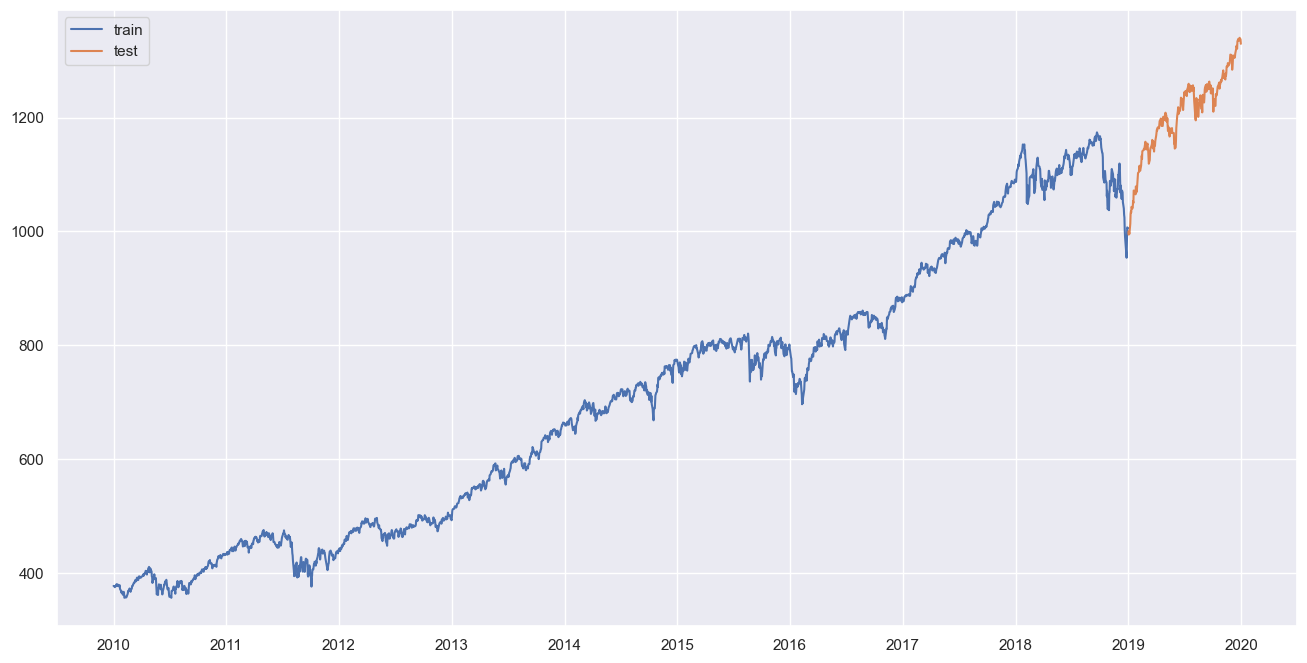

In [4]:
df_train, df_test = split_df_prediciton(df_market_port, _resampling='None')

plt.figure(figsize=(16,8))
plt.plot(df_train, label='train')
plt.plot(df_test, label='test')
plt.legend()

In [5]:
def ts_analysis(_df, _resampling='1W', _debug=False, _method = 0, _plot = True, 
                _export = False, 
                _export_filename='ts_model_save.sav'):
    """
    classicial time series method used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df_market_port input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0, not used
        _plot = True, if True, function displays plot, otherwise not
        _export = False, if True model (after fit) will be saved to _export_filename
        _export_filename name of the file used of saving model if _export = True
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 36 # 3 months
        steps = 12
    elif _resampling == '1W':
        lags = 156
        steps = 52
    else:
        # todo proper error handling, now default is used
        lags = 156
        steps = 52
    
    # train test split
    df_train, df_test = split_df_prediciton(_df, _resampling='None')

    # resampling 
    df_train_resampled = df_train.resample(_resampling).mean() 
    df_test_resampled = df_test.resample(_resampling).mean()
    
    # overwrite steps
    steps = df_test_resampled.shape[0]
    
    # plot - if _debug is True
    if _debug == True:
        plt.figure(figsize=(16,8))
        plt.plot(df_train_resampled);

        tsa =seasonal_decompose(df_train_resampled)
        fig=tsa.plot()
        fig.set_size_inches((16, 8))
        fig.tight_layout()
        plt.show();
    
    # log transform + diffs
    df_train_resampled_log = np.log(df_train_resampled) 

    df_train_resampled_log_1 = df_train_resampled_log.diff().dropna()
    
    if _debug == True:
        pd.plotting.autocorrelation_plot(df_train_resampled_log_1);
        res=sm.tsa.stattools.adfuller(df_train_resampled_log_1)
        print ("First order diff transformation p-value:",res[1])


    df_train_resampled_log_2 = df_train_resampled_log_1.diff().dropna()
    if _debug == True:
        pd.plotting.autocorrelation_plot(df_train_resampled_log_2);
        res=sm.tsa.stattools.adfuller(df_train_resampled_log_2)
        print ("Second order diff transformation p-value:",res[1])
    
    # auto correlation functions of second order diff
    if _debug == True:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
        
        plot_acf(df_train_resampled_log_2,lags = lags,ax=ax1)  ## was 36 in case on 1M
        plot_pacf(df_train_resampled_log_2,lags = lags,ax=ax2) ## was 36 in case on 1M
        
        plt.show();
    
    # SARIMA fit default: (1,1,1)
    model_sm = sm.tsa.SARIMAX(df_train_resampled_log, order=(1,1,1), seasonal_order = (1,1,1 ,steps))  ## 1M: seasonal_order = (0,1,1,12)
    model_sm_fitted = model_sm.fit()
    print(model_sm_fitted.summary())
    
    # export model
    if _export == True:
        pickle.dump(model_sm_fitted, open(root_dir + '\\' + _export_filename, 'wb'))

    # Forecasting with a confidence interval    
    prediction_log = model_sm_fitted.get_forecast(steps = steps).summary_frame()  
    prediction = np.exp(prediction_log)

    if _plot == True:
        fig, ax = plt.subplots(figsize = (15,5))

        plt.plot(df_train_resampled, label = "train")
        plt.plot(df_test_resampled, label = "test")

        prediction['mean'].plot(ax = ax, style = 'k--', label = "prediction") # Plotting the mean

        ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); 
        plt.axvline(x= df_test.index[0], color='orange'); 
        plt.legend()
    
    # calculate RMSE
    rmse =  np.sqrt(mean_squared_error(df_test_resampled, prediction['mean']))
    
    return np.round(rmse,4)


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  471
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 53)   Log Likelihood                1125.461
Date:                            Mon, 05 Jun 2023   AIC                          -2240.921
Time:                                    23:23:30   BIC                          -2220.756
Sample:                                01-03-2010   HQIC                         -2232.949
                                     - 01-06-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0038      0.217      0.018      0.986      -0.422       0.429
ma.L1          0.1818      0.218   

122.4601

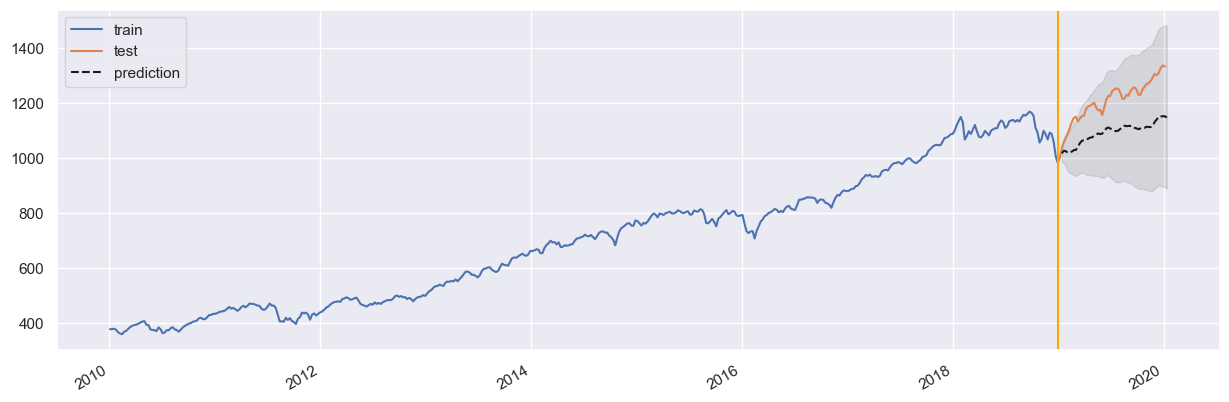

In [6]:
ts_analysis(df_market_port, _resampling = '1W', _debug = False, _plot = True)

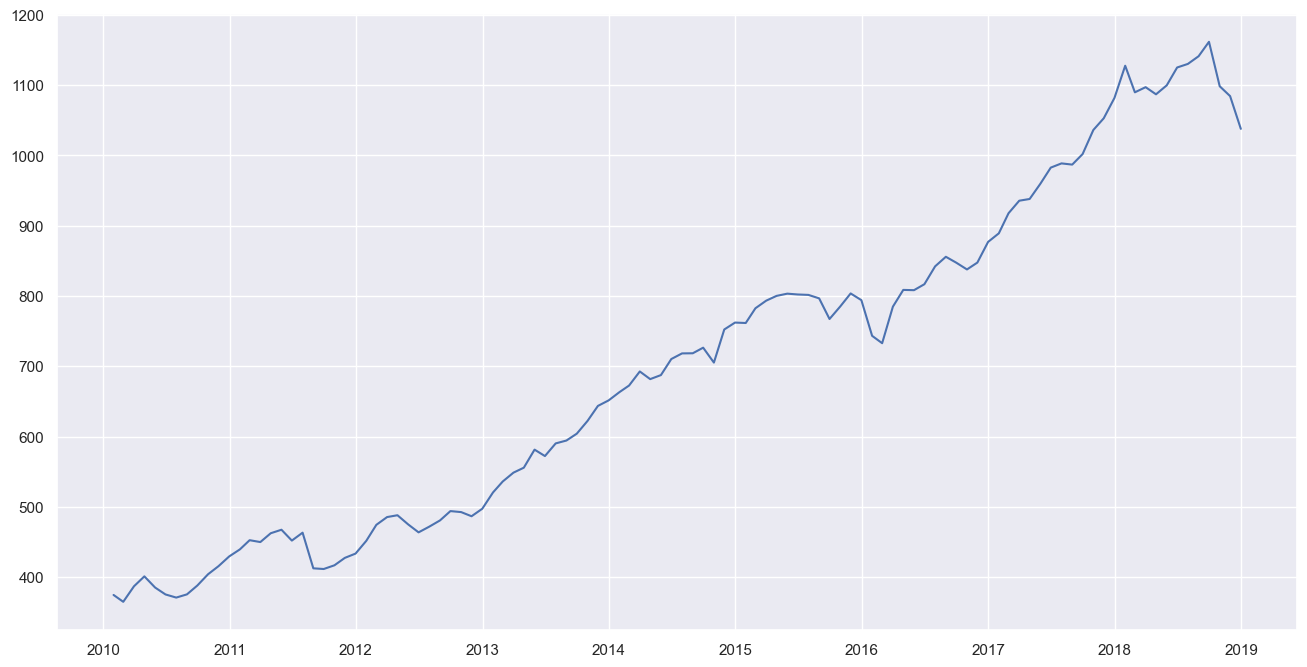

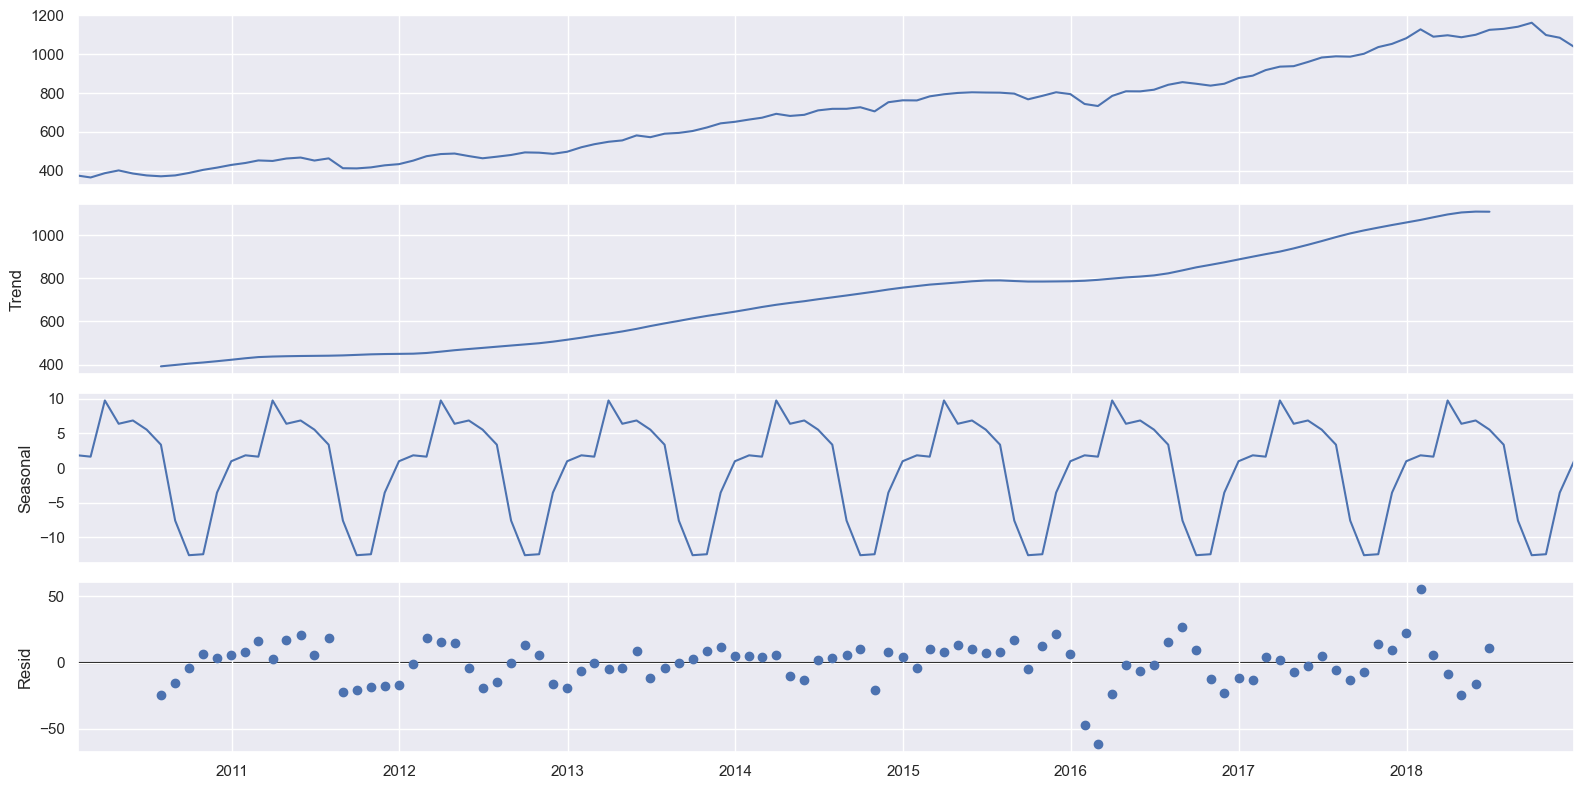

First order diff transformation p-value: 7.100776429040988e-15
Second order diff transformation p-value: 2.257325550906049e-08


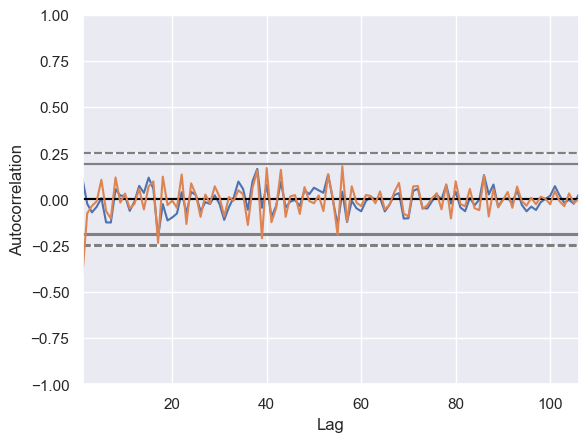

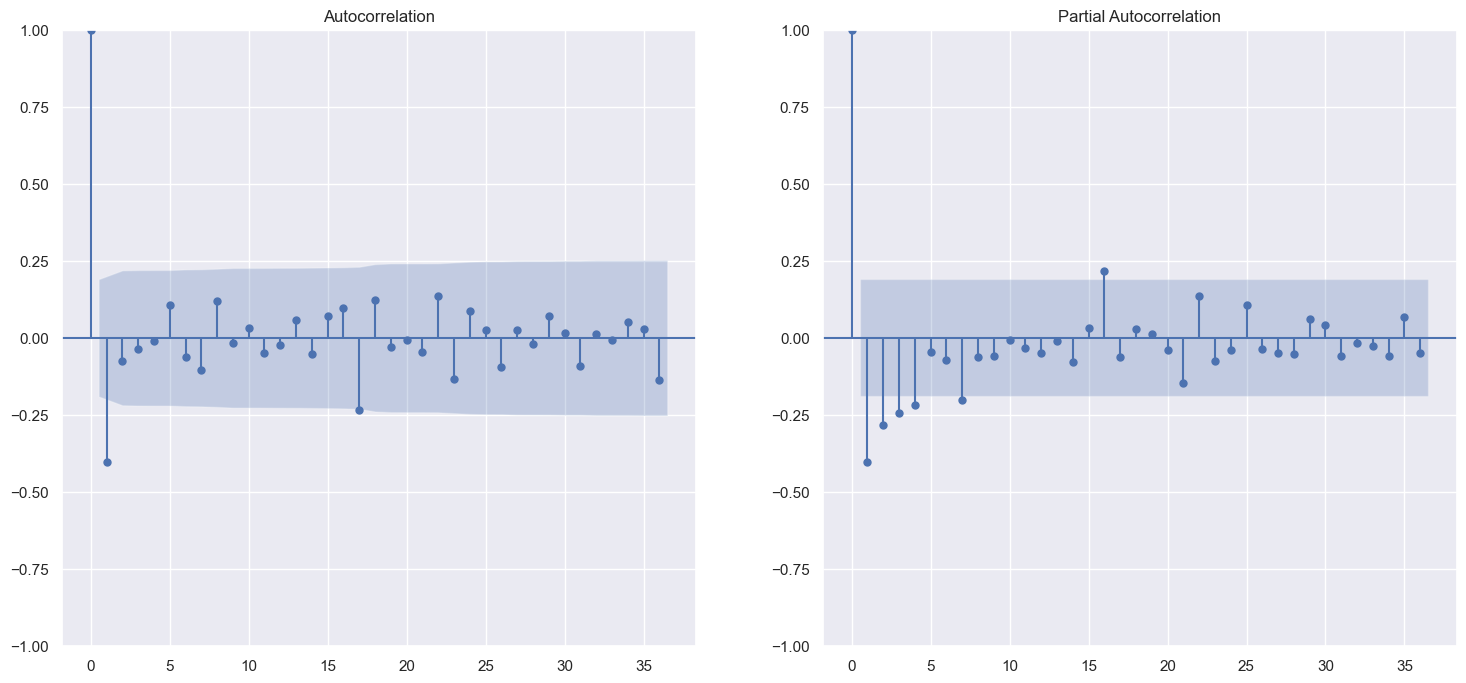

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 195.542
Date:                            Mon, 05 Jun 2023   AIC                           -381.084
Time:                                    23:24:03   BIC                           -368.315
Sample:                                01-31-2010   HQIC                          -375.924
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1184      0.716     -0.165      0.869      -1.522       1.285
ma.L1          0.2490      0.712   

109.1629

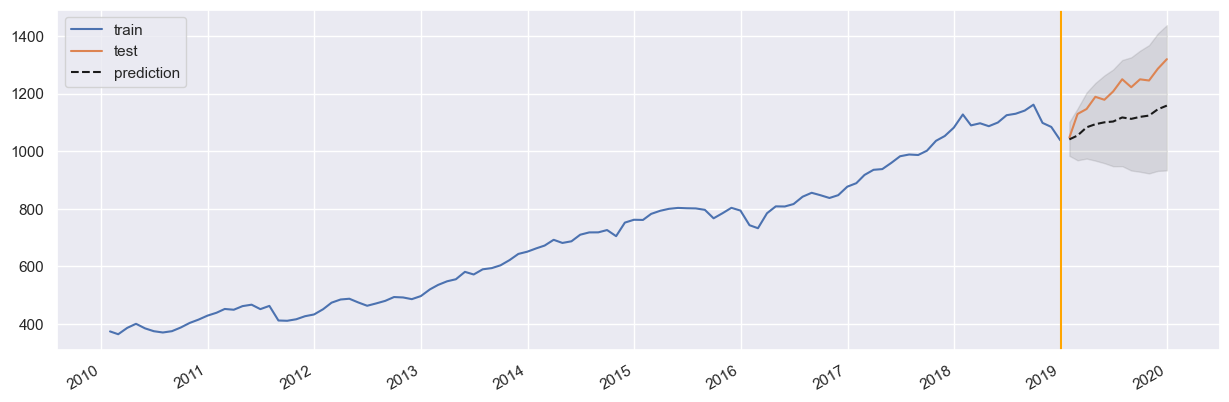

In [7]:
ts_analysis(df_market_port, _resampling = '1M', _debug = True, _plot = True, _export = True)

In [5]:
# check export

_export_filename='ts_model_alt_port_3_1M.sav'
    
loaded_model = pickle.load(open(root_dir + '\\' + _export_filename, 'rb'))
print(loaded_model.summary())



                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 199.069
Date:                            Thu, 08 Jun 2023   AIC                           -388.137
Time:                                    18:22:15   BIC                           -375.368
Sample:                                01-31-2010   HQIC                          -382.978
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1362      1.114      0.122      0.903      -2.047       2.319
ma.L1         -0.0390      1.142   

In [14]:
import numpy as np
100*(np.exp(loaded_model.get_forecast(steps=12).predicted_mean)[-1] -1000) /1000

16.387718774765723

In [9]:
def lin_analysis(_df, _resampling='1W', _debug=False, _method = 0, _plot = True,
                 _export = False, 
                _export_filename='lin_model_save.sav'):
    """
    linear regression method based forecast used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df_market_port input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0 , 0: RandomForestRegressior, 1: Naiv, 2: Sesional naiv, 3: direct with RFR
        _plot = True, if True, function displays plot, otherwise not
        _export = False, if True model (after fit) will be saved to _export_filename, works only with method 0 !
        _export_filename name of the file used of saving model if _export = True
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 24 # 
        steps = 12
    elif _resampling == '1W':
        lags = 104
        steps = 52
    else:
        # todo proper error handling, now default is used
        lags = 104
        steps = 52

    # resampling
    df_resampled = _df.resample(_resampling).mean() 
    
    # create data frame
    df_lin = pd.DataFrame(df_resampled,index=df_resampled.index)
    df_lin['Time'] = np.arange(len(df_lin.index))
    df_lin.columns = ['Stock','Time']
    
    # create month/year as variable
    df_lin['Month'] = df_lin.index.month
    df_lin['Year'] = df_lin.index.year
    
    # create lags as variable
    for i in range(12,18,1):
        df_lin['Lag_'+ str(i)] = df_lin.Stock.shift(i)
    df_lin['Lag_24'] = df_lin.Stock.shift(24)
    
    # remove nan-s due to lags
    df_lin = df_lin.dropna(axis=0)

    # train test split
    df_train_lin, df_test_lin = split_df_prediciton(df_lin,_resampling = _resampling)
    
    # overwrite steps -- TODO not used, remove
    steps = df_test_lin.shape[0]

    # split of target variables from features
    X_train = df_train_lin[df_train_lin.columns[2:]] ## 2 is used because Time column is there, otherwise 1
    y_train = df_train_lin['Stock']
    
    # split of target variables from features
    X_test = df_test_lin[df_test_lin.columns[2:]] ## 2 is used because Time column is there, otherwise 1
    y_test = df_test_lin['Stock']
    
    if _method == 0:
        # Random forest regressor
        
        # model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # export model
        if _export == True:
            pickle.dump(model, open(root_dir + '\\' + _export_filename, 'wb'))

        # prediction
        y_pred = model.predict(X_test)

        # plot feature importance
        if _debug == True:
            feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            feat_importances.nlargest(15).sort_values().plot(kind='barh', title='Feature Importance');

        rmse =  np.sqrt(mean_squared_error(y_test, y_pred)) 

        # for plot:
        y_pred_plot = y_pred
        y_pred_legend = 'Random Forest Regressor'
        
    elif _method == 1:
        # naiv approach
        
        forecast = np.mean(df_train_lin['Stock'][-steps:]) # was 24 
        y_pred_mean = np.ones(steps,)*forecast # was 12

        rmse =  np.sqrt(mean_squared_error(y_test, y_pred_mean)) 

        # for plot:
        y_pred_plot = y_pred_mean
        y_pred_legend = 'Naiv approach'

    elif _method == 2:
        # sesional
        
        y_pred_seas = df_train_lin['Stock'][-steps:] # was 12
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_seas))

        # for plot:
        y_pred_plot = y_pred_seas
        y_pred_legend = 'Benchmark Seasonal naive'
        
    elif _method == 3:
        for i in range(1,steps,1): # was 12 but it works with 1M only
            df_lin['Lag_'+str(i)] = df_lin.Stock.shift(i)
        
        horizons = steps
        cutoff_index = df_lin.shape[0]-horizons

        predictions = []
        pred_index = []
        y_true_m3 = []
        
        for h in np.arange(1,horizons+1,1):
            train, test = df_lin[(steps*2):cutoff_index], df_lin[cutoff_index:cutoff_index+h] # was 24
            if h != 1:
                if _debug == True:
                    print("Horizon: ", h)
                    print("Columns: ", df_lin.columns[1:-h+1])
                    print("")
                X_train_m3 = train[df_lin.columns[1:-h+1]]
                X_test_m3 = test[df_lin.columns[1:-h+1]]
            else: 
                if _debug == True:
                    print("Horizon: ", h)
                    print("Columns: ", df_lin.columns[1:])
                X_train_m3 = train[df_lin.columns[1:]]
                X_test_m3 = test[df_lin.columns[1:]]
                
            y_train_m3 = train['Stock']
            y_test_m3 = test['Stock']
            
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train_m3, y_train_m3)
            
            y_pred_m3 = model.predict(X_test_m3)
            predictions.append(y_pred_m3[h-1])
            pred_index.append(X_test_m3.index[h-1])
            y_true_m3.append(y_test_m3[h-1])

        rmse = np.sqrt(mean_squared_error(y_true_m3, predictions))

        y_pred_plot = predictions
        y_pred_legend = 'Direct approach with Random Forest Regressor'
        
    else:
        # do nothing, should drop an error
        rmse = 0
        
        y_pred_plot = y_test
        y_pred_legend = 'Empty method'

    
    # plot
    if _plot == True:
        fig, ax = plt.subplots(figsize = (15,5))

        plt.plot(df_train_lin.index, df_train_lin.Stock, c='b', label='train')
        plt.plot(X_test.index, y_test, c='orange', label='test')
        plt.plot(X_test.index, y_pred_plot, c = 'r', label='prediction')
        plt.axvline(x= df_test_lin.index[0], color='orange'); 
        plt.legend()

        plt.xlabel('Time')
        plt.ylabel('Stock')
        plt.title(y_pred_legend)
        plt.show()
    
    return np.round(rmse,4)
    

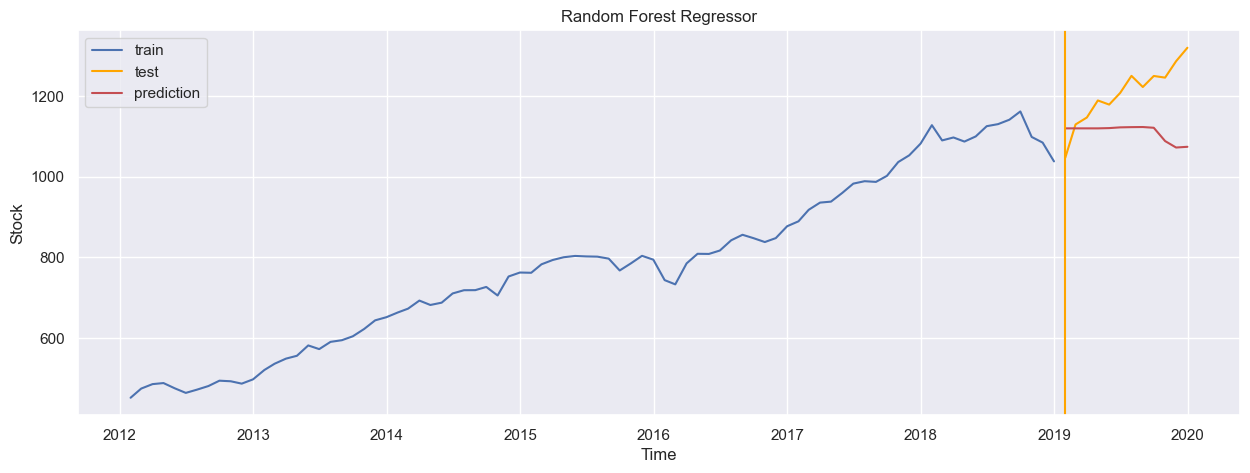

127.4856

In [10]:
lin_analysis(df_market_port, _resampling = '1M', _debug = False, _method = 0, _plot = True, _export = True)

In [11]:
# check export
_export_filename='lin_model_save.sav'
    
loaded_model = pickle.load(open(root_dir + '\\' + _export_filename, 'rb'))

# create data frame again
df_resampled = df_market_port.resample('1M').mean() 

# create data frame
df_lin = pd.DataFrame(df_resampled,index=df_resampled.index)
df_lin['Time'] = np.arange(len(df_lin.index))
df_lin.columns = ['Stock','Time']

# create month/year as variable
df_lin['Month'] = df_lin.index.month
df_lin['Year'] = df_lin.index.year

# create lags as variable
for i in range(12,18,1):
    df_lin['Lag_'+ str(i)] = df_lin.Stock.shift(i)
df_lin['Lag_24'] = df_lin.Stock.shift(24)

# remove nan-s due to lags
df_lin = df_lin.dropna(axis=0)

# train test split
df_train_lin, df_test_lin = split_df_prediciton(df_lin,_resampling = '1M')

X_test = df_test_lin[df_test_lin.columns[2:]] ## 2 is used because Time column is there, otherwise 1
y_test = df_test_lin['Stock']

y_pred = loaded_model.predict(X_test)

 
print(np.sqrt(mean_squared_error(y_test, y_pred))) 



127.48559024150252


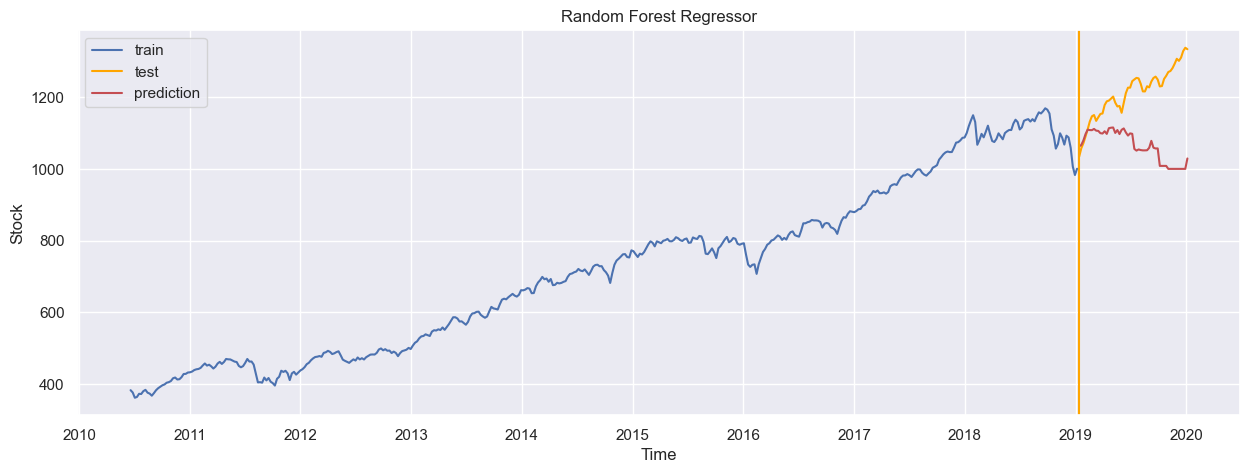

179.3774

In [12]:
lin_analysis(df_market_port, _resampling = '1W', _debug = False, _method = 0, _plot = True)

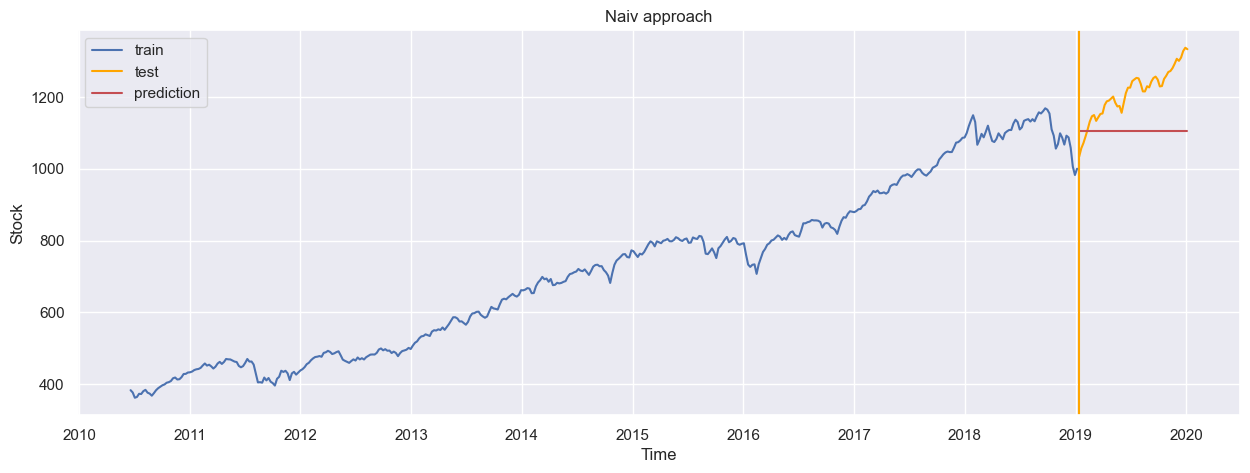

126.9097

In [13]:
lin_analysis(df_market_port, _resampling = '1W', _debug = False, _method = 1, _plot = True)

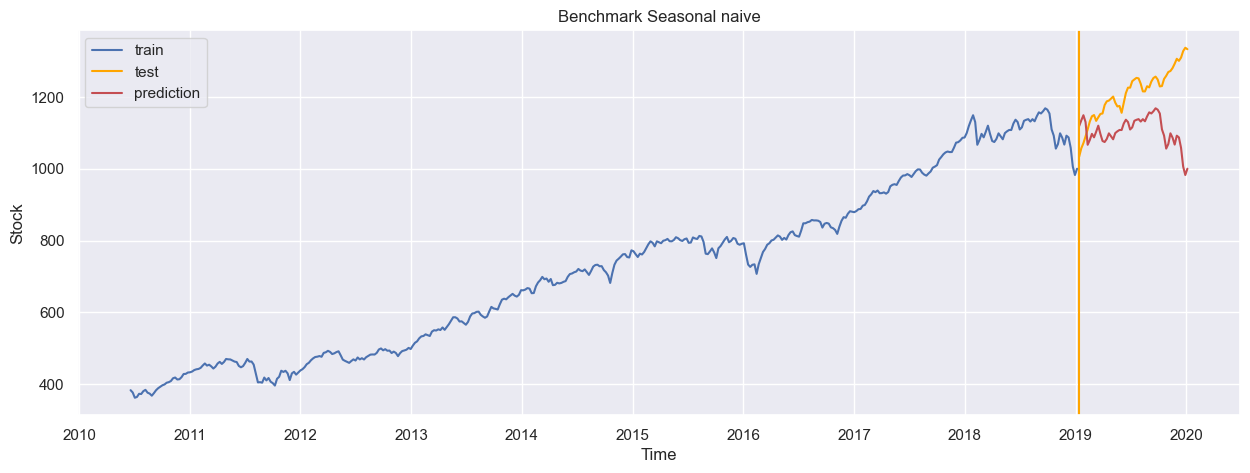

139.4017

In [14]:
lin_analysis(df_market_port, _resampling = '1W', _debug = False, _method = 2, _plot = True)

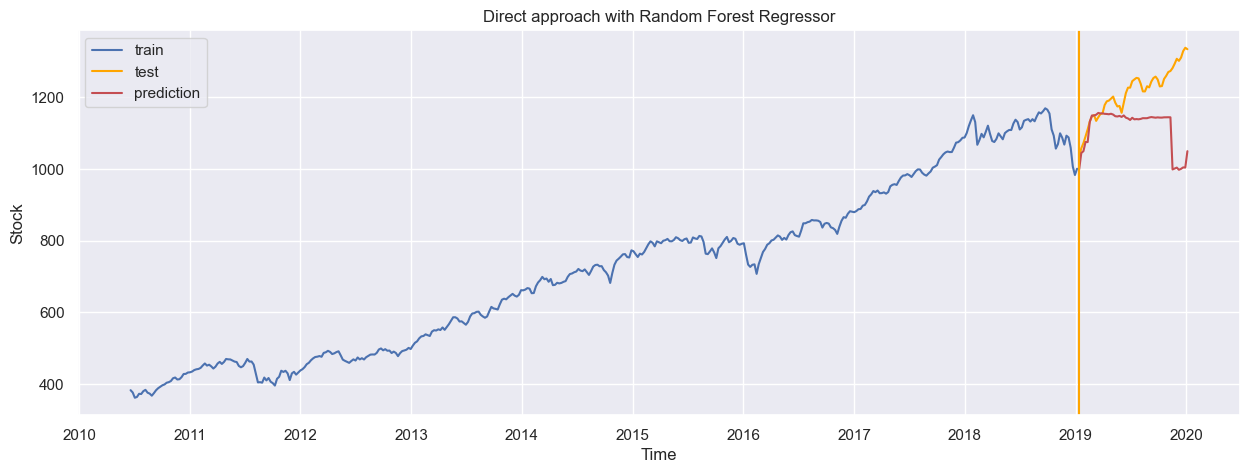

137.3547

In [15]:
lin_analysis(df_market_port, _resampling = '1W', _debug = False, _method = 3, _plot = True)

In [16]:
def prophet_analysis(_df, _resampling='1W', _debug=False, _method = 0, _plot = True,
                 _export = False, 
                _export_filename='pt_model_save.sav'):
    """
    Prophet forecast used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df_market_port input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0 , not used
        _plot = True, if True, function displays plot, otherwise not
        _export = False, if True model (after fit) will be saved to _export_filename,
        _export_filename name of the file used of saving model if _export = True
           
    output: RMSE of the prediction
    """
    # params
    if _resampling == '1M':
        lags = 36 # 3 months TODO: lags is not used, but should be instead of steps
        steps = 12
        freq = 'MS'
    elif _resampling == '1W':
        lags = 156
        steps = 52
        freq = 'W'
    else:
        # todo proper error handling, now default is used
        lags = 156
        steps = 52

    # resampling
    df_resampled = _df.resample(_resampling).mean() 
    
    # create data frame ---- train
    df_pt = pd.DataFrame(df_resampled, index=df_resampled.index)
    df_pt['ds'] = df_pt.index
    df_pt.columns = ['y','ds']

    if _debug == True:
        print(df_pt.head())
       
    # remove nan-s -- not needed
    #df_pt = df_pt.dropna(axis=0)

    # train test split
    df_train_pt, df_test_pt = split_df_prediciton(df_pt,_resampling = _resampling)
    
    # overwrite steps -- TODO check
    steps = df_test_pt.shape[0]

    # model creation and fit
    model_pt = pt.Prophet(interval_width=0.95)
    model_pt.fit(df_train_pt)
    # INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
    # INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
    
    # export model
    if _export == True:
        pickle.dump(model_pt, open(root_dir + '\\' + _export_filename, 'wb'))
    
    # prediction df_market_port
    future_dates = model_pt.make_future_dataframe(periods = steps, freq = freq) # TODO MS ws montlhy?
    
    # prediction
    forecast = model_pt.predict(future_dates)
    
    # plot model component
    if _debug == True: 
        model_pt.plot_components(forecast)

    if _debug == True:
        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

    # model plot
    if _plot == True:
        model_pt.plot(forecast, uncertainty=True,figsize = (15,5))

        #ax = y_save.plot()
        plt.plot(df_test_pt.index, df_test_pt['y'], c='orange', label='test')
        plt.axvline(x= df_test_pt.index[0], color='orange'); 

    # RSME calculation
    rmse =  np.sqrt(mean_squared_error(df_test_pt['y'], forecast.trend.tail(steps)))
    
    return np.round(rmse,4)


23:26:52 - cmdstanpy - INFO - Chain [1] start processing
23:26:54 - cmdstanpy - INFO - Chain [1] done processing


38.3442

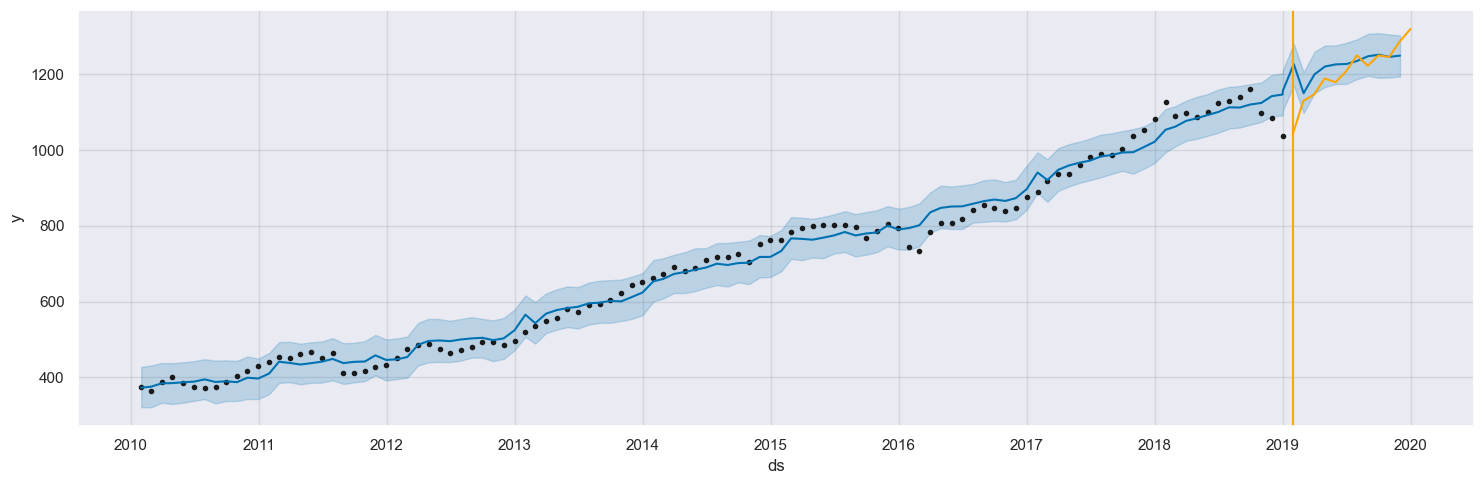

In [17]:
prophet_analysis(df_market_port, _resampling = '1M', _debug = False, _method = 0, _plot = True, _export = True)

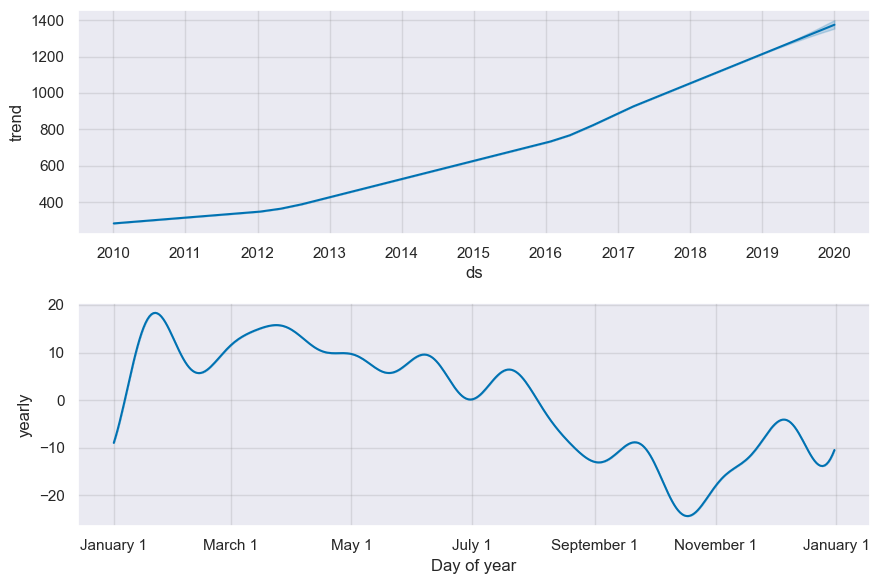

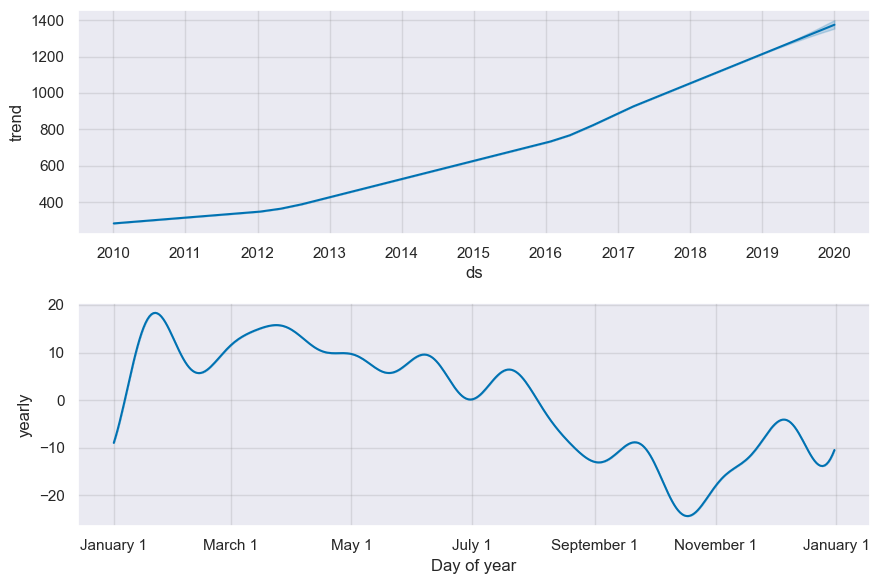

In [15]:
# check export
_export_filename='pt_model_alt_port_3_1W.sav'
    
loaded_model = pickle.load(open(root_dir + '\\' + _export_filename, 'rb'))
# prediction DF
future_dates = loaded_model.make_future_dataframe(periods = 12, freq = 'MS') 

# prediction
forecast = loaded_model.predict(future_dates)

# plot model component
loaded_model.plot_components(forecast)


In [18]:
forecast.iloc[-1, 1]

1374.9830166580705

23:27:47 - cmdstanpy - INFO - Chain [1] start processing
23:27:47 - cmdstanpy - INFO - Chain [1] done processing


42.1713

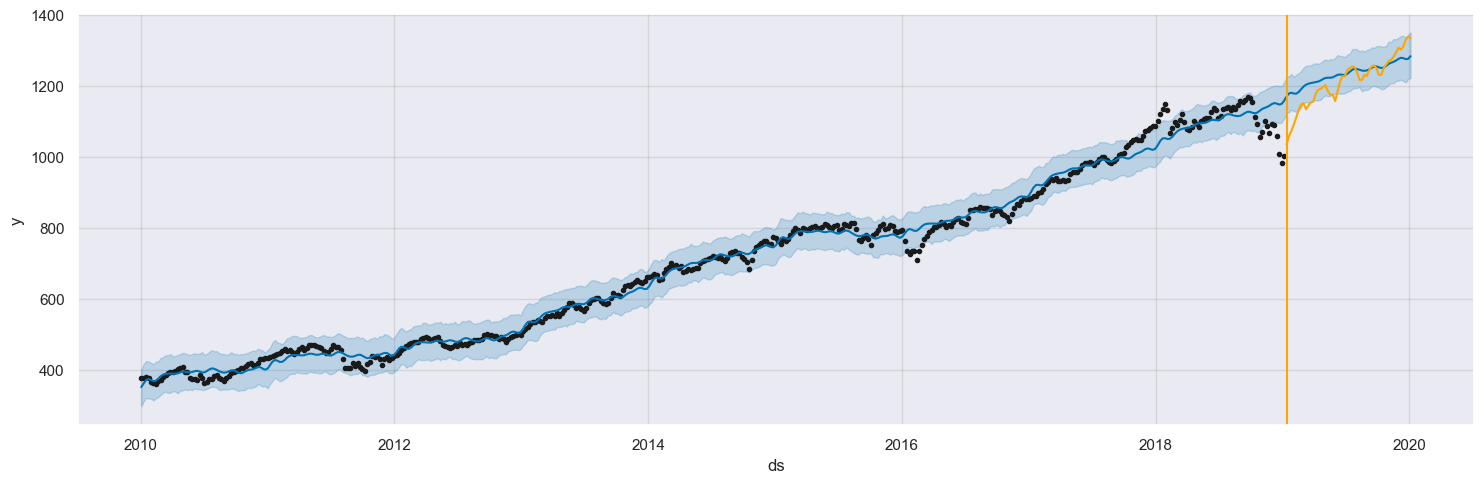

In [19]:
prophet_analysis(df_market_port, _resampling = '1W', _debug = False, _method = 0, _plot = True)

In [20]:
def deepl_analysis(_df, _resampling='1W', _debug=False, _method = 0, _plot = True,
                 _export = False, 
                _export_filename='dl_model_save.sav'):
    """
    deep learning forecast used on dataframe, provides charts, prediction, and calculates RMSE
    inputs:
        _df_ = df_market_port input data frame

        _resampling = 'M', frequency of resampling, could be 1M, 1W, etc
        _debug=True , if true additional plots have been shown
        _method = 0 , not used
        _plot = True, if True, function displays plot, otherwise not
        _export = False, if True model (after fit) will be saved to _export_filename,
        _export_filename name of the file used of saving model if _export = True
           
    output: RMSE of the prediction
    """
    
    # TODO DL part
    
    # RSME calculation
    rmse =  0 
    
    return np.round(rmse,4)
